## 1. Pre-training the Auto-Encoder

In this notebook, we pre-train the auto-encoder for reconstruction. In their paper, Carr et al. define the motion encoder `E_M` and the privacy encoder `E_P`, which are implemented identically as described below.

![Encoder Architecture](figures/encoder.png)

Here, the input size 75 refers to the frame length `T` of each sequence of 3D coordinates in the dataset. The output of each encoder is a motion embedding and a privacy embedding respectively. The acronyms are defined using the Pytorch implementations:

- C2D: Convolution 2D
- LR: Leaky ReLU
- Up: Upsample
- MP: Max Pooling
- RP2D: Reflection Pad 2D

This stage includes 5 epochs of paired pre-training, followed by 20 epochs of unpaired pre-training.

### 1.1 Paired Pre-training

In order to separate the embeddings, we first start by pre-training the autoencoder in the paired setting for 5 epochs.

In the paired setting, the model is trained with "carefully matched sets of skeleton motions".

#### 1.1.1 Defining the dataset

In [ ]:
from sitc.data.ntu60 import NTU60

ntu60_dataset = NTU60(num_frames=75, paired=True)

print(f"==========\nNTU 60 Dataset\n==========")
print(f"Number of samples: {len(ntu60_dataset)}")
print(f"Number of frames: {ntu60_dataset.max_frames}")
print(f"Number of joints: {ntu60_dataset.num_joints}")

In [ ]:
sample = ntu60_dataset[0]
print(f"Sample ID: {sample['name']}")
print(f"Camera ID: {sample['camera']}")
print(f"Action ID: {sample['action']}")
print(f"Person ID: {sample['person']}")
print(f"Paired sample ID: {sample['paired']}")

In [ ]:
sample['keypoints']["original"].shape

In [ ]:
sample["keypoints"]["dummy"].shape

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(ntu60_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
print(f"Number of batches: {len(train_dataloader)}")

#### 1.1.2 Instantiating the Autoencoder

In [ ]:
from sitc.models.autoencoder import PairedAE

paired_ae = PairedAE()
paired_ae.cuda()

#### 1.1.3 Defining hyperparameters

**Defining the cross-reconstruction loss**

The loss is defined as

$$L_{rec} = \mathbb{E}_{\mathbf{s_{a,p}},\mathbf{s_{a',p'}}\sim\mathcal{S}}\Bigl[||\mathit{D}(\mathit{E_M}(\mathbf{s_{a,p}}), \mathit{E_P}(\mathbf{s_{a',p'}})) - \mathbf{s_{a,p'}} ||^2\Bigr]$$

where $\mathbf{s_{a,p}}$ serves as the original skeleton and $\mathbf{s_{a',p'}}$ serves as the dummy skeleton.

In [ ]:
import torch.nn as nn

class CrossReconstructionLoss(nn.Module):
    def __init__(self):
        super(CrossReconstructionLoss, self).__init__()
    
    def forward(self, orig_inputs, dummy_inputs, targets):
        pass

**Defining the triplet loss**

This is to ensure the distinctness of embeddings by explicitly requiering the separation of two latent spaces encoded in $E_M$, $E_P$. It ensures motion embeddings are close in an embedding space while privacy embeddings are close in a distance embedding space.

$$L_{trip} = \mathbb{E}_{\mathbf{s_{a,p}},\mathbf{s_{a',p'}}\sim\mathcal{S}}\Bigl[\max(0, ||\mathit{E_M}(\mathbf{s}_{a,p}) - \mathit{E_M}(\mathbf{s}_{a',p})||^2 - ||\mathit{E_M}(\mathbf{s}_{a,p}) - \mathit{E_M}(\mathbf{s}_{a,p'})||^2 + \gamma) + \max(0, ||\mathit{E_P}(\mathbf{s}_{a,p}) - \mathit{E_P}(\mathbf{s}_{a',p})||^2 - ||\mathit{E_P}(\mathbf{s}_{a,p}) - \mathit{E_P}(\mathbf{s}_{a,p'})||^2 + \gamma)\Bigr]$$

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self):
        super(TripletLoss, self).__init__()
    
    def forward(self, orig_inputs, dummy_inputs, targets):
        pass

**Defining the latent consistency loss**

This loss ensures the same action by different acrots has consistent motion embedding in the latent space. It also ensures the same actor performing different actions has consistent privacy embedding in the latent space.

$$L_{latent} = \mathbb{E}_{\mathbf{s_{a,p}},\mathbf{s_{a',p'}}\sim\mathcal{S}}\Bigl[\mathit{MSE}(\mathit{E_M}(\mathbf{s}_{a,p}), \mathit{E_M}(\mathbf{s}_{a,p'})) + \mathit{MSE}(\mathit{E_P}(\mathbf{s}_{a,p}), \mathit{E_P}(\mathbf{s}_{a',p}))\Bigr]$$

where MSE denotes the mean-square error.

In [ ]:
class LatentConsistencyLoss(nn.Module):
    def __init__(self):
        super(LatentConsistencyLoss, self).__init__()
    
    def forward(self):
        pass

**Defining the end-effector loss**

The end-effector loss is defined to handle the skeleton spacial size difference. The end-effectors of the original and the retargeted skeleton must have the same normalised velocity. This loss prevents foot sliding and ensures steady positioning when the original skeleton is still.


$$L_{ee} = \mathbb{E}_{\mathbf{s}\sim\mathcal{S}}\sum_{e\in\mathit{E}}|| \frac{\mathit{V}_{\mathbf{s}_e} - \mathit{V}_{\mathbf{\hat{s}}_e}}{\mathit{h_e}} ||^2$$

where $\mathit{E}$ is the set of end effectors, $\mathit{h_e}$ is the length of the kinematic chain for end effector $\mathit{e}$, $\mathit{V_{\mathbb{s}_e}}$ is the velocity of the skeleton's end effector $e$ kinematic chain.

In [ ]:
class EELoss(nn.Module):
    def __init__(self):
        super(EELoss, self).__init__()

    def forward(inputs, targets):
        pass

**Defining the total loss**

The total loss for the autoencoder paired training is 

$$L_{paired} = L_{unpaired} + \alpha_{cross}L_{cross} + \alpha_{ee}L_{ee} + \alpha_{trip}L_{trip} + \alpha_{latent}L_{latent}$$

where the hyperparameters are set to $\alpha_{cross}=0.1$, $\alpha_{ee}=1$, $\alpha_{trip}=1$, $\alpha_{latent}=10$.

In [ ]:
from sitc.training.loss_functions import AELoss

class PairedAELoss(nn.Module):
    def __init__(self, alpha_rec=2, alpha_smooth=3, alpha_cross=0.1, alpha_ee=1, alpha_triplet=1, alpha_latent=10):
        super(PairedAELoss, self).__init__()
        self.alpha_rec = alpha_rec
        self.alpha_smooth = alpha_smooth
        self.alpha_cross = alpha_cross
        self.alpha_ee = alpha_ee
        self.alpha_triplet = alpha_triplet
        self.alpha_latent = alpha_latent
    
    def forward(self):
        pass
        
loss_paired = PairedAELoss()

**Defining the optimiser and LR scheduler**

In [ ]:
optimiser = torch.optim.Adam(paired_ae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=50, gamma=0.5)

#### 1.1.4 Training the model

In [ ]:
import datetime 

now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

num_epochs = 5
train_loss_running = 0.
best_loss = float('inf')

for epoch in range(num_epochs):
    for i, batch in enumerate(train_dataloader):

        batch = NTU60.move_batch_to_device(batch, 'cuda')

        optimiser.zero_grad()

        orig_inputs = batch['keypoints']["original"].float()
        dummy_inputs = batch['keypoints']["dummy"].float()
        
        outputs = paired_ae(orig_inputs, dummy_inputs)

        # TODO: Define the cross-reconstruction loss


        

        loss = loss_fn(orig_inputs, dummy_inputs, outputs)

        loss.backward()
        optimiser.step()

        train_loss_running += loss.item()
        iteration = epoch * len(train_dataloader) + i

        if iteration % 100 == 0:
            train_loss = train_loss_running / 100
            print(f"Epoch {epoch}, Batch {i}, Loss: {train_loss}")

            if train_loss < best_loss:
                #torch.save(ae.state_dict(), f"sitc/runs/ae_pretraining_paired/model_best_{now}.ckpt")
                best_loss = train_loss

            train_loss_running = 0.
        
        # TODO: add validation loop

    scheduler.step()


### 1.2 Unpaired Pre-training

We further prime the models using unpaired pre-training for 20 epochs.

#### 1.2.1 Defining the unpaired dataset

In [1]:
from sitc.data.ntu60 import NTU60

train_dataset = NTU60(num_frames=75)
val_dataset = NTU60(num_frames=75, split='val')

print(f"==========\nNTU 60 Dataset\n==========")
print(f"Number of total samples: {len(train_dataset) + len(val_dataset)}")
print(f"Number of train samples: {len(train_dataset)}")
print(f"Number of test samples: {len(val_dataset)}")
print(f"Number of frames: {train_dataset.max_frames}")
print(f"Number of joints: {train_dataset.num_joints}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
NTU 60 Dataset
Number of total samples: 46231
Number of train samples: 30757
Number of test samples: 15474
Number of frames: 75
Number of joints: 25


**Visualising the data**

In [2]:
sample = train_dataset[0]
print(f"Sample ID: {sample['name']}")
print(f"Camera ID: {sample['camera']}")
print(f"Action ID: {sample['action']}")
print(f"Person ID: {sample['person']}")

Sample ID: S001C003P004R002A038
Camera ID: 3
Action ID: 38
Person ID: 4


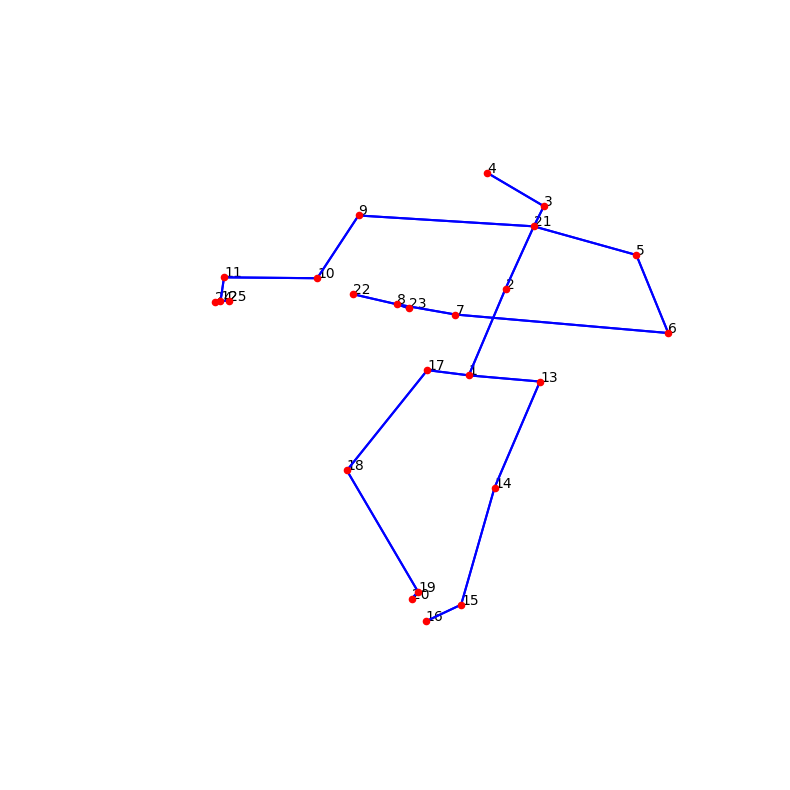

In [3]:
from sitc.utils.visualisation import plot_point_cloud, plot_skeleton
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

keypoints = sample["keypoints"]
joints = keypoints[:, 0, :].T

# I don't know why this crashes at the moment
#plot_point_cloud(joints, train_dataset.lines)

plot_skeleton(joints, train_dataset.lines)


In [4]:
import torch

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
print(f"Number of training batches: {len(train_dataloader)}")

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
print(f"Number of validation batches: {len(val_dataloader)}")

Number of training batches: 241
Number of validation batches: 121


#### 1.2.2 Instantiating the Autoencoder

In [5]:
from sitc.models.autoencoder import AE

ae = AE()

#### 1.2.3 Defining hyperparameters

**Defining the reconstruction loss**

The loss is defined as

$$L_{rec} = \mathbb{E}_{\mathbf{s}\sim\mathcal{S}}\Bigl[||\mathit{D}(\mathit{E_M}(\mathbf{s}), \mathit{E_P}(\mathbf{s})) - \mathbf{s} ||^2\Bigr]$$

This is equivalent to the MSE loss.

In [6]:
from sitc.training.loss_functions import ReconstructionLoss

loss_rec = ReconstructionLoss()

**Defining the smooth loss**

The smooth loss is defined as

$$L_{smooth} = \mathbb{E}_{\mathbf{s}\sim\mathcal{S}}\Biggl[\frac{\sqrt{\sum_i^J|\sum_j^T(\hat{s}_{i,j}-\hat{s}_{i,j+1})^2 - \sum_j^T(\mathbf{s}_{i,j}-\mathbf{s}_{i,j+1}^2)}}{J\times T}\Biggr]$$

In [7]:
from sitc.training.loss_functions import SmoothLoss

loss_smooth = SmoothLoss()

**Defining the total loss**

The total loss for the autoencoder pre-training is

$$L_{ae} = \alpha_{rec}L_{rec} + \alpha_{smooth}L_{smooth}$$

where $\alpha_{rec}$, $\alpha_{smooth}$ are hyperparameters.

In [8]:
from sitc.training.loss_functions import AELoss

loss_unpaired = AELoss()
loss_unpaired.to('cuda')

AELoss()

**Defining the optimiser and LR scheduler**

In [9]:
import torch 

optimiser = torch.optim.Adam(ae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=50, gamma=0.5)

#### 1.1.4 Training

In [11]:
import datetime 

now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

num_epochs = 20
loss_running = 0.
best_loss = float('inf')

# move the model to the GPU
ae.cuda()

for epoch in range(num_epochs):
    ae.train(True)

    for i, batch in enumerate(train_dataloader):

        batch = NTU60.move_batch_to_device(batch, 'cuda')

        optimiser.zero_grad()

        inputs = batch['keypoints'].float()

        outputs = ae(inputs)

        loss = loss_unpaired(inputs, outputs)

        loss.backward()
        optimiser.step()
        
        loss_running += loss.item()
        iteration = epoch * len(train_dataloader) + i

        if iteration % 100 == 99:
            train_loss = loss_running / 100
            print(f"Epoch {epoch}, Batch {i}, Loss: {train_loss}")

            loss_running = 0.

    
    vloss_running = 0.
    ae.eval()

    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):

            batch = NTU60.move_batch_to_device(batch, 'cuda')

            vinputs = batch['keypoints'].float()

            voutputs = ae(vinputs)

            vloss = loss_unpaired(vinputs, voutputs)

            vloss_running += vloss.item()
            
    avg_vloss = vloss_running / (i+1)
    print(f"Validation Loss: {avg_vloss}")

    if avg_vloss < best_loss:
        torch.save(ae.state_dict(), f"sitc/runs/ae_pretraining_unpaired/model_best_{now}_epoch{epoch}.ckpt")
        best_loss = avg_vloss


    scheduler.step()


Epoch 0, Batch 99, Loss: 0.3032335093617439
Epoch 0, Batch 199, Loss: 0.3041948063671589
Validation Loss: 0.317362121806657
Epoch 1, Batch 58, Loss: 0.2963970799744129
Epoch 1, Batch 158, Loss: 0.2933939203619957
Validation Loss: 0.29089975812711005
Epoch 2, Batch 17, Loss: 0.3465580993890762
Epoch 2, Batch 117, Loss: 0.22264556527137758
Epoch 2, Batch 217, Loss: 0.23112627893686294
Validation Loss: 0.25691879645359417
Epoch 3, Batch 76, Loss: 0.22925200968980788
Epoch 3, Batch 176, Loss: 0.1858799535036087
Validation Loss: 0.16708052084465658
Epoch 4, Batch 35, Loss: 0.16598355576395987
Epoch 4, Batch 135, Loss: 0.14287536047399044
Epoch 4, Batch 235, Loss: 0.11221318982541562
Validation Loss: 0.10855973518091785
Epoch 5, Batch 94, Loss: 0.09944419167935849
Epoch 5, Batch 194, Loss: 0.0980613461881876
Validation Loss: 0.08852383155714381
Epoch 6, Batch 53, Loss: 0.09394813872873783
Epoch 6, Batch 153, Loss: 0.0914588363468647
Validation Loss: 0.09263753558485961
Epoch 7, Batch 12, Los